### This notebook is a tutorial for the PERT infer scRT module.

PERT takes binned read counts with called copy number states as input from scWGS. Cells are split into high-confidence G1/2-phase and unknown phase sets of cells before passing data into the probabilistic model.

Here, we are analyzing simulated data from 400 S-phase cells and 400 G1-phase cells with subclonal and cell-specific CNAs. HMMcopy has been run on the simulated data to obtain the `copy` and `state` columns.

In contrast to the original notebook, this notebook demonstrates PERT's ability to identify high-confidence G1/2-phase set of cells when no ground-truth labels are provided. This notebook also demonstrates how PERT predicts cell cycle phase using the inferred fraction of replicated bins per cell.

In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.infer_scRT import scRT
from scdna_replication_tools.plot_pert_output import plot_model_results
from scdna_replication_tools.compute_ccc_features import compute_ccc_features
from scdna_replication_tools.predict_cycle_phase import predict_cycle_phase

In [2]:
# load the simulated data from the paper
# this corresponds to the data seen in simulated dataset P8.2 which has subclonal and cell-specific CNAs
cn_s = pd.read_csv('data/P8.2/s_phase_cells_hmmcopy_trimmed.csv.gz', dtype={'chr': str})
cn_g1 = pd.read_csv('data/P8.2/g1_phase_cells_hmmcopy_trimmed.csv.gz', dtype={'chr': str})
cn_s.head()

cell_id chr    start      end  reads        gc       map      copy  state  \
0  cell_S_0  11   500000  1000000    147  0.576436  0.994259  1.940695      2   
1  cell_S_0  11  1500000  2000000    221  0.550580  0.999164  2.644951      2   
2  cell_S_0  11  2000000  2500000    111  0.551398  0.997696  1.331687      2   
3  cell_S_0  11  2500000  3000000    163  0.522456  0.998346  1.836685      2   
4  cell_S_0  11  3500000  4000000    204  0.450204  0.990193  2.363708      2   

   multiplier  ...  true_G1_state  library_id  true_reads_norm  \
0           4  ...            1.0        ABCD               99   
1           4  ...            1.0        ABCD              148   
2           4  ...            1.0        ABCD               74   
3           4  ...            1.0        ABCD              109   
4           4  ...            1.0        ABCD              137   

   true_reads_raw  true_rep  true_p_rep    true_t  observed_cn_state  \
0           147.0       1.0    0.999477  0.526486                2.0   
1           221.0       1.0    0.999215  0.526486                2.0   
2           111.0       1.0    0.998821  0.526486                2.0   
3           163.0       1.0    0.996731  0.526486                2.0   
4           204.0       1.0    0.993944  0.526486                2.0   

   true_cell_frac_rep  cluster_id  
0            0.526876           A  
1            0.526876           A  
2            0.526876           A  
3            0.526876           A  
4            0.526876           A  

[5 rows x 46 columns]

In [3]:
cn_g1.head()

cell_id chr    start      end  reads        gc       map      copy  state  \
0  cell_G_0  11   500000  1000000    387  0.576436  0.994259  2.147705      2   
1  cell_G_0  11  1500000  2000000    354  0.550580  0.999164  2.041947      2   
2  cell_G_0  11  2000000  2500000    327  0.551398  0.997696  1.883890      2   
3  cell_G_0  11  2500000  3000000    315  0.522456  0.998346  1.895786      2   
4  cell_G_0  11  3500000  4000000    268  0.450204  0.990193  1.802248      2   

   multiplier  ...  true_G1_state  library_id  true_reads_norm  \
0           2  ...            2.0        ABCD              226   
1           2  ...            2.0        ABCD              207   
2           2  ...            2.0        ABCD              191   
3           2  ...            2.0        ABCD              184   
4           2  ...            2.0        ABCD              157   

   true_reads_raw  observed_cn_state  true_cell_frac_rep  true_rep  \
0           387.0                2.0                 0.0       0.0   
1           354.0                2.0                 0.0       0.0   
2           327.0                2.0                 0.0       0.0   
3           315.0                2.0                 0.0       0.0   
4           268.0                2.0                 0.0       0.0   

   true_p_rep  true_t  cluster_id  
0         0.0     1.0           C  
1         0.0     1.0           C  
2         0.0     1.0           C  
3         0.0     1.0           C  
4         0.0     1.0           C  

[5 rows x 46 columns]

In [4]:
# add the replication columns for the G1-phase cells
cn_g1['true_rep'] = 0.0
cn_g1['true_p_rep'] = 0.0
cn_g1['true_t'] = 1.0

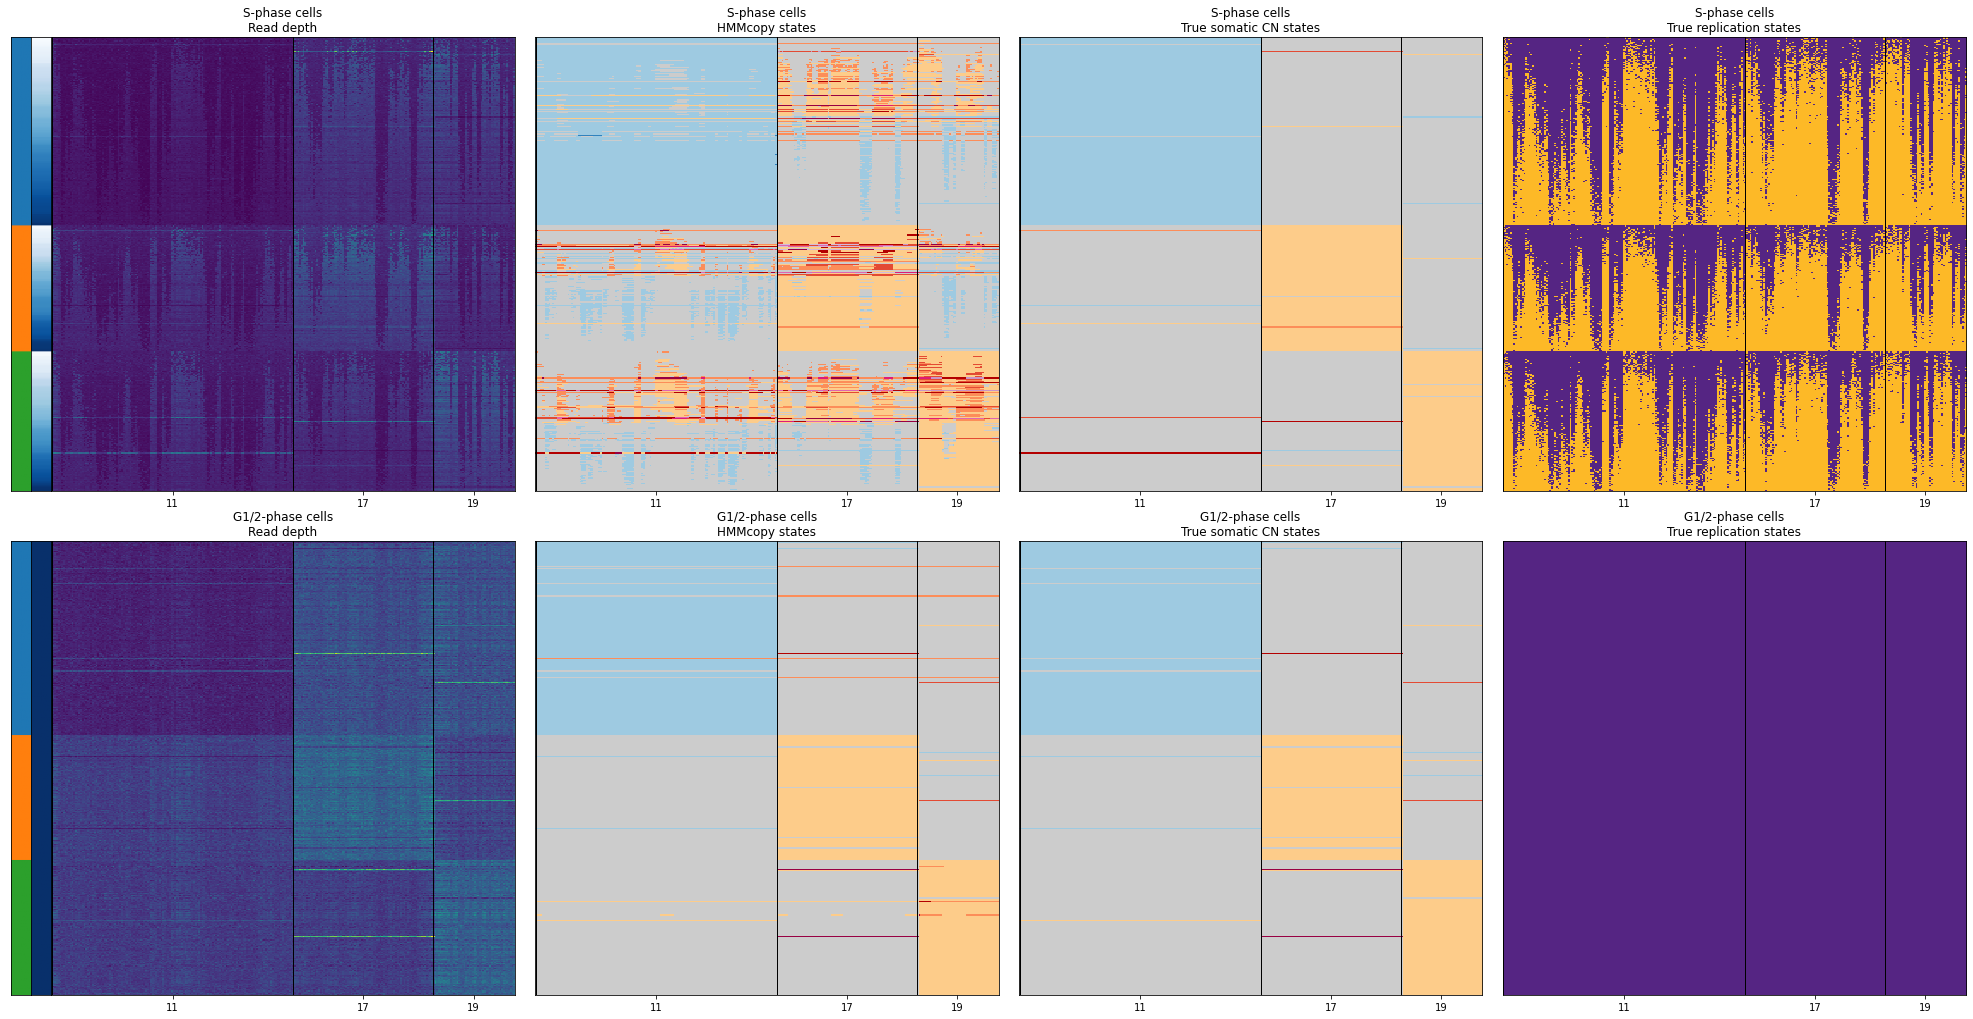

In [5]:
# plot the true simulated data
plot_model_results(
    cn_s, cn_g1, clone_col='clone_id', second_sort_col='true_t', 
    input_cn_col='state', output_cn_col='true_G1_state', 
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states'
)
plt.show()

In the above plots, note how the HMMcopy `state` column accurately reflects somatic CN for G1/2-phase cells but not S-phase cells. This is because the HMMcopy model is not designed to handle the high copy number of S-phase cells. Given that replication origins are disproportionately located in high GC regions, some of the replication signal gets regressed out during per-cell GC normalization (1st step of hmmcopy). Thus, many replicated vs unreplicated bins in S-phase cells don't have clear 2:1 ratios, leading HMMcopy to select an erroneously high ploidy multiplier (2nd step of hmmcopy). Even if the ploidy multiplier is correct, the HMMcopy states only reflect the replicated signal that remains after GC normalization, so the states should be ignored in S-phase cells.

### First we need to identify the high confidence G1/2-phase cells based on per-cell features.

In [6]:
# note the true cell cycle phase of each cell and merge all the cells into one dataframe
cn_s['true_phase'] = 'S'
cn_g1['true_phase'] = 'G1/2'

cn = pd.concat([cn_s, cn_g1], ignore_index=True)
cn.head()

cell_id chr    start      end  reads        gc       map      copy  state  \
0  cell_S_0  11   500000  1000000    147  0.576436  0.994259  1.940695      2   
1  cell_S_0  11  1500000  2000000    221  0.550580  0.999164  2.644951      2   
2  cell_S_0  11  2000000  2500000    111  0.551398  0.997696  1.331687      2   
3  cell_S_0  11  2500000  3000000    163  0.522456  0.998346  1.836685      2   
4  cell_S_0  11  3500000  4000000    204  0.450204  0.990193  2.363708      2   

   multiplier  ...  library_id  true_reads_norm  true_reads_raw  true_rep  \
0           4  ...        ABCD               99           147.0       1.0   
1           4  ...        ABCD              148           221.0       1.0   
2           4  ...        ABCD               74           111.0       1.0   
3           4  ...        ABCD              109           163.0       1.0   
4           4  ...        ABCD              137           204.0       1.0   

   true_p_rep    true_t  observed_cn_state  true_cell_frac_rep  cluster_id  \
0    0.999477  0.526486                2.0            0.526876           A   
1    0.999215  0.526486                2.0            0.526876           A   
2    0.998821  0.526486                2.0            0.526876           A   
3    0.996731  0.526486                2.0            0.526876           A   
4    0.993944  0.526486                2.0            0.526876           A   

   true_phase  
0           S  
1           S  
2           S  
3           S  
4           S  

[5 rows x 47 columns]

In [7]:
# compute per-cell features for all cells
cn, cell_features = compute_ccc_features(
    cn, rpm_col='true_reads_norm', cn_col='state', 
    clone_col='clone_id', madn_col='madn', lrs_col='lrs',
    num_reads_col='total_reads_per_cell', bk_col='breakpoints'
)
cell_features.head()

cell_id clone_id      madn       lrs  total_reads_per_cell  \
0       cell_S_0        A  0.171489  0.066719                 37530   
271     cell_S_1        B  0.130547  0.451731                 51496   
542    cell_S_10        B  0.115896 -0.002604                 47388   
813   cell_S_100        B  0.147288  0.144286                 48770   
1084  cell_S_101        A  0.192771  0.011424                 39223   

      breakpoints  corrected_madn  corrected_breakpoints  
0             390        0.017119             241.821958  
271           281       -0.017107             122.343891  
542           298       -0.033734             139.343891  
813           563       -0.001677             404.343891  
1084          477        0.039216             328.821958

In [8]:
cn.head()

cell_id chr    start      end  reads        gc       map      copy  state  \
0  cell_S_0  11   500000  1000000    147  0.576436  0.994259  1.940695      2   
1  cell_S_0  11  1500000  2000000    221  0.550580  0.999164  2.644951      2   
2  cell_S_0  11  2000000  2500000    111  0.551398  0.997696  1.331687      2   
3  cell_S_0  11  2500000  3000000    163  0.522456  0.998346  1.836685      2   
4  cell_S_0  11  3500000  4000000    204  0.450204  0.990193  2.363708      2   

   multiplier  ...  observed_cn_state  true_cell_frac_rep  cluster_id  \
0           4  ...                2.0            0.526876           A   
1           4  ...                2.0            0.526876           A   
2           4  ...                2.0            0.526876           A   
3           4  ...                2.0            0.526876           A   
4           4  ...                2.0            0.526876           A   

   true_phase  true_reads_norm_clone_norm      madn       lrs  \
0           S                    0.775649  0.171489  0.066719   
1           S                    1.202266  0.171489  0.066719   
2           S                    0.611211  0.171489  0.066719   
3           S                    0.964020  0.171489  0.066719   
4           S                    1.336063  0.171489  0.066719   

   total_reads_per_cell  corrected_madn  corrected_breakpoints  
0                 37530        0.017119             241.821958  
1                 37530        0.017119             241.821958  
2                 37530        0.017119             241.821958  
3                 37530        0.017119             241.821958  
4                 37530        0.017119             241.821958  

[5 rows x 53 columns]

In [9]:
# merge the true_phase information back into the cell_features dataframe
cell_features = cell_features.merge(cn[['cell_id', 'true_phase']].drop_duplicates(), on='cell_id')
cell_features.head()

cell_id clone_id      madn       lrs  total_reads_per_cell  breakpoints  \
0    cell_S_0        A  0.171489  0.066719                 37530          390   
1    cell_S_1        B  0.130547  0.451731                 51496          281   
2   cell_S_10        B  0.115896 -0.002604                 47388          298   
3  cell_S_100        B  0.147288  0.144286                 48770          563   
4  cell_S_101        A  0.192771  0.011424                 39223          477   

   corrected_madn  corrected_breakpoints true_phase  
0        0.017119             241.821958          S  
1       -0.017107             122.343891          S  
2       -0.033734             139.343891          S  
3       -0.001677             404.343891          S  
4        0.039216             328.821958          S

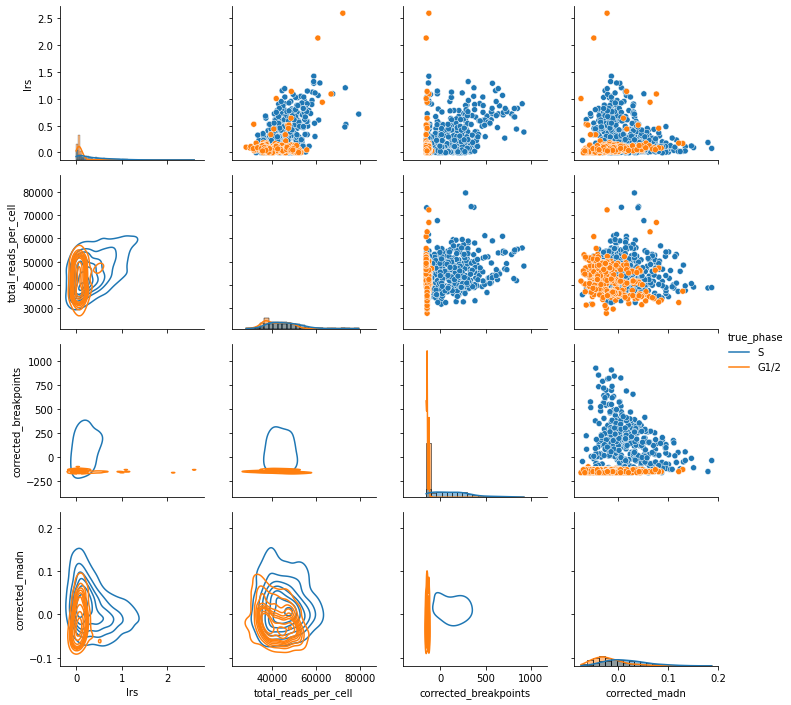

In [10]:
# plot a distribution of the per-cell features, colored by the true cell cycle phase
plot_cols = ['lrs', 'total_reads_per_cell', 'corrected_breakpoints', 'corrected_madn', 'true_phase']
g = sns.PairGrid(cell_features[plot_cols], hue='true_phase')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True)
g.add_legend()
plt.show()

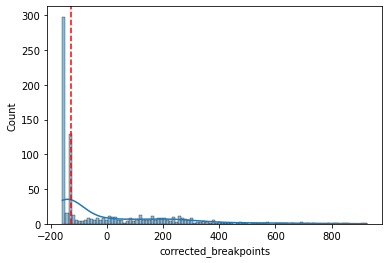

(400,)

In [11]:
# split the data so cells with the 400 highest corrected breakpoints are in the G1/2-phase dataset
# sort the cells by corrected breakpoints
cell_features = cell_features.sort_values('corrected_breakpoints', ascending=False)
# get the cell_ids for the top 400 cells and the threshold for the 401st cell
top_400_cell_ids = list(cell_features['cell_id'].iloc[:400].values)
thresh = cell_features['corrected_breakpoints'].iloc[400]

# look at distribution of corrected breakpoints to set a threshold for identifying the high-confidence G1/2-phase cells
sns.histplot(cell_features['corrected_breakpoints'], kde=True, bins=100)
# plot a vertical line at the threshold
plt.axvline(thresh, color='red', linestyle='--')
plt.show()

# # split the data into G1/2-phase and S-phase
cn_s_input = cn[cn['cell_id'].isin(top_400_cell_ids)].reset_index(drop=True)
cn_g_input = cn[~cn['cell_id'].isin(top_400_cell_ids)].reset_index(drop=True)
cn_g_input.cell_id.unique().shape

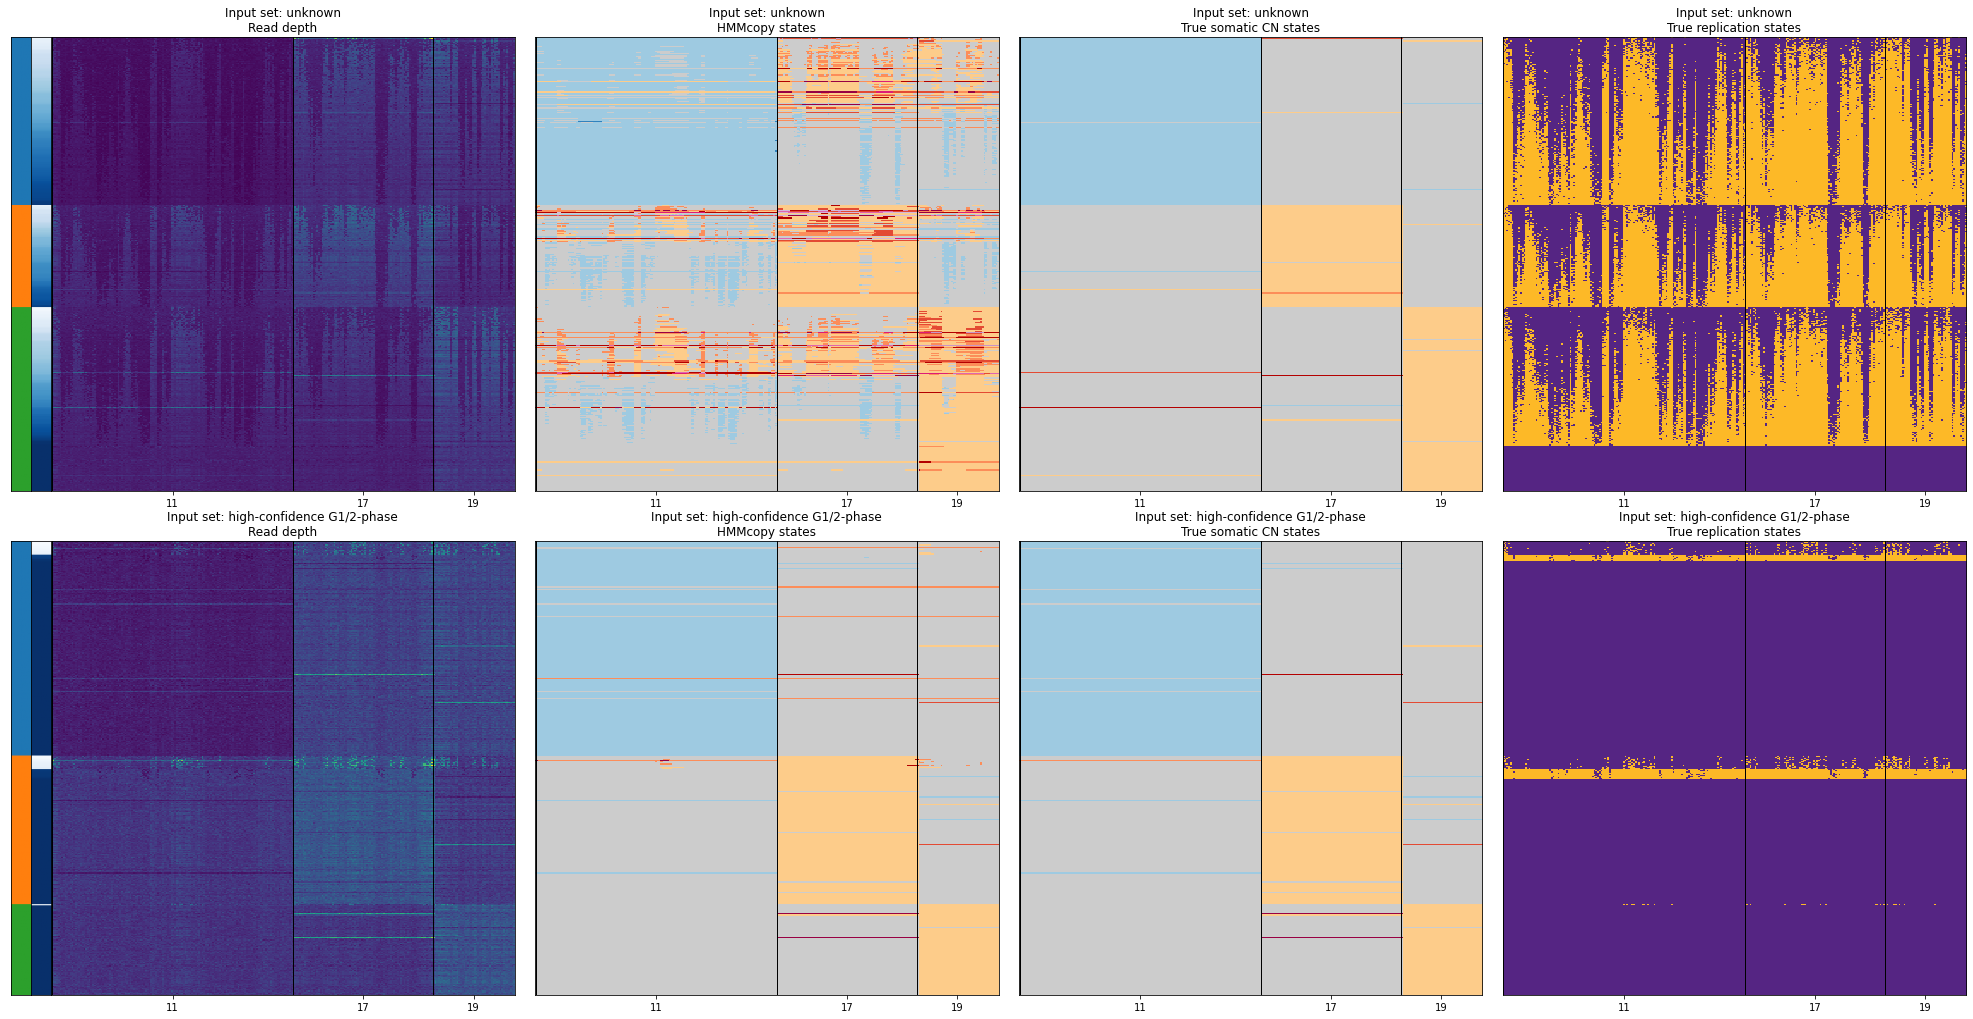

In [12]:
# plot the true simulated data according to the input splits
plot_model_results(
    cn_s_input, cn_g_input, clone_col='clone_id', second_sort_col='true_t',
    input_cn_col='state', output_cn_col='true_G1_state',
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states',
    top_title_prefix='Input set: unknown', bottom_title_prefix='Input set: high-confidence G1/2-phase',
)
plt.show()

### Now we will run PERT to jointly infer scRT and CN states for all cells.

We will  use a small number of iterations to speed up the analysis but this can sometimes lead to inaccurate results. In practice, we recommend using >1000 iterations. One can also adjust the `learning_rate` and `rel_tol` away from default values of 0.05 and 1e-6, respectively, to achieve a desired optimization routine.

In [13]:
# temporarily remove columns that don't get used by PERT
temp_cn_s = cn_s_input[['cell_id', 'chr', 'start', 'end', 'gc', 'state', 'library_id', 'true_reads_norm']]
temp_cn_g1 = cn_g_input[['cell_id', 'chr', 'start', 'end', 'gc', 'clone_id', 'state', 'library_id', 'true_reads_norm']]

print('number of cells in S-phase: ', len(temp_cn_s['cell_id'].unique()))
print('number of cells in G1-phase: ', len(temp_cn_g1['cell_id'].unique()))
print('number of loci in S-phase: ', len(temp_cn_s[['chr', 'start']].drop_duplicates()))
print('number of loci in G1-phase: ', len(temp_cn_g1[['chr', 'start']].drop_duplicates()))

number of cells in S-phase:  400
number of cells in G1-phase:  400
number of loci in S-phase:  271
number of loci in G1-phase:  271


In [14]:
%%capture

# create scRT object with input columns denoted
scrt = scRT(temp_cn_s, temp_cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='true_reads_norm', rt_prior_col=None,
            cn_state_col='state', gc_col='gc', cn_prior_method='g1_composite', max_iter=300)

# run inference using PERT
cn_s_with_scrt, supp_s_output, cn_g_with_scrt, supp_g_output = scrt.infer(level='pyro')

the lack of an error above makes me think that there's some issue when `temp_cn_s` and `temp_cn_g` have different numbers of cells... I'll look into this...

In [15]:
cn_s_with_scrt.head()

cell_id chr   start      end        gc  state library_id  \
0  cell_G_107  11  500000  1000000  0.576436      2       ABCD   
1  cell_G_169  11  500000  1000000  0.576436      2       ABCD   
2  cell_G_172  11  500000  1000000  0.576436      2       ABCD   
3  cell_G_173  11  500000  1000000  0.576436      2       ABCD   
4  cell_G_176  11  500000  1000000  0.576436      2       ABCD   

   true_reads_norm clone_id  model_cn_state  model_rep_state  model_tau  \
0               78        C               2              0.0   0.322250   
1               77        C               2              0.0   0.141931   
2              148        C               2              0.0   0.195907   
3              178        C               2              0.0   0.202034   
4              207        C               2              0.0   0.213381   

     model_u  model_rho  
0  53.674995   0.411525  
1  59.100590   0.411525  
2  57.002205   0.411525  
3  55.262192   0.411525  
4  56.894661   0.411525

In [16]:
cn_g_with_scrt.head()

cell_id chr   start      end        gc clone_id  state library_id  \
0    cell_G_0  11  500000  1000000  0.576436        C      2       ABCD   
1    cell_G_1  11  500000  1000000  0.576436        A      1       ABCD   
2   cell_G_10  11  500000  1000000  0.576436        B      2       ABCD   
3  cell_G_100  11  500000  1000000  0.576436        C      2       ABCD   
4  cell_G_101  11  500000  1000000  0.576436        C      2       ABCD   

   true_reads_norm  model_cn_state  model_rep_state  model_tau    model_u  \
0              226               2              0.0   0.235386  65.007385   
1              136               1              0.0   0.252631  69.648331   
2              180               2              0.0   0.252355  55.223091   
3              159               2              1.0   0.923052  42.830769   
4              172               2              0.0   0.245013  53.042568   

   model_rho  
0   0.411525  
1   0.411525  
2   0.411525  
3   0.411525  
4   0.411525

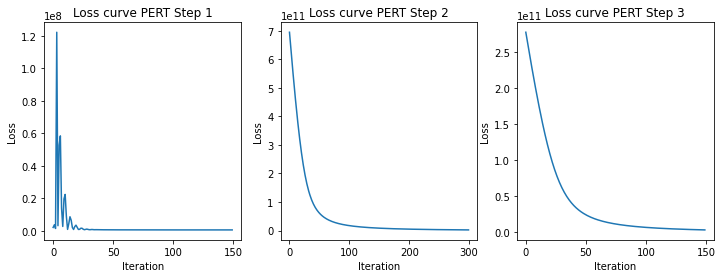

In [17]:
# plot the loss curve for 'loss_s' and 'loss_g' param values in the supp_s_output and supp_g_output dataframes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data=supp_s_output.query("param=='loss_g'"), x='level', y='value', ax=ax[0])
sns.lineplot(data=supp_s_output.query("param=='loss_s'"), x='level', y='value', ax=ax[1])
sns.lineplot(data=supp_g_output.query("param=='loss_s'"), x='level', y='value', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Loss')
    ax[i].set_title('Loss curve PERT Step {}'.format(i+1))

plt.show()

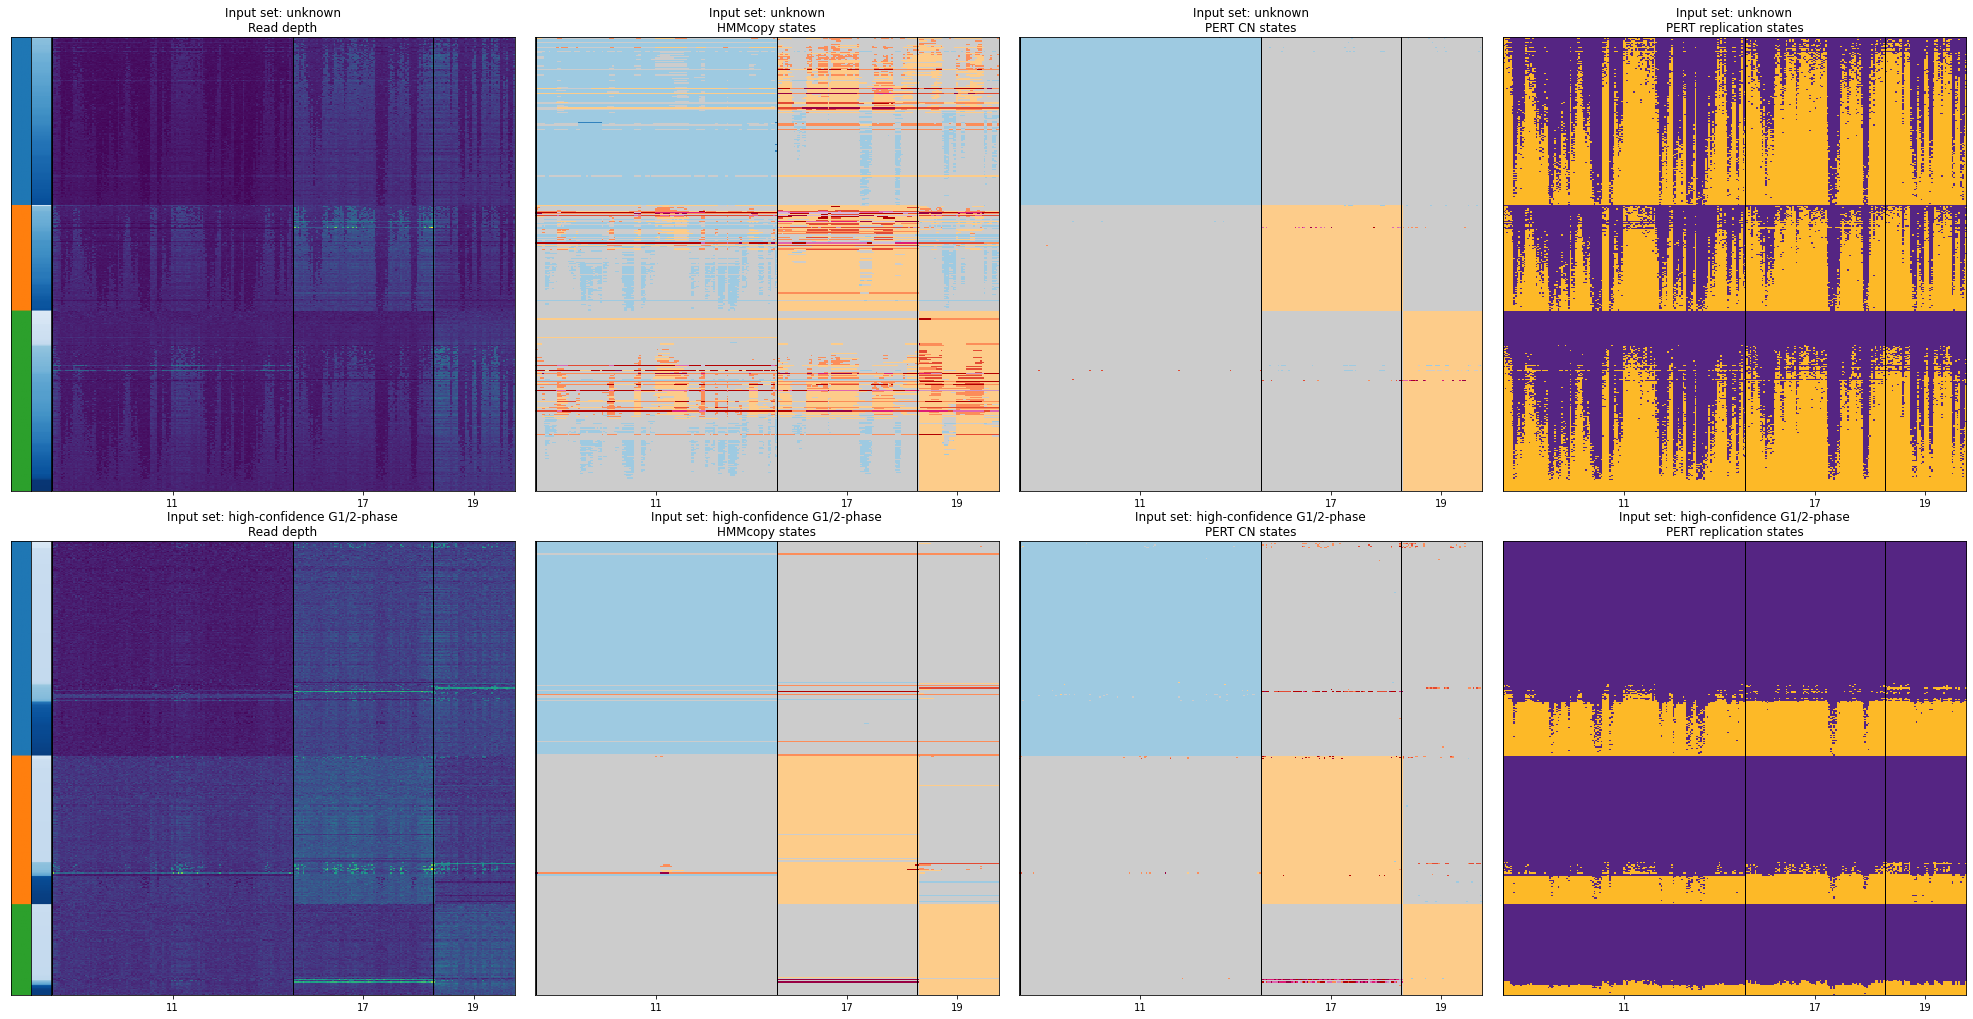

In [18]:
# plot the results of the inference
plot_model_results(
    cn_s_with_scrt, cn_g_with_scrt, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states',
    top_title_prefix='Input set: unknown', bottom_title_prefix='Input set: high-confidence G1/2-phase'
)
plt.show()

### Finally, we use the model output to predict cell cycle phase.

Looking at the results above, we can see that there are some cells in the high-confidence G1/2-phase set that look to be replicating (particularly in clones A & B) and other cells in the unkown input set that look to be fully replicated/unreplicated (particularly in clone C). This occurs because thresholding on per-cell features used such as breakpoint counts or read depth variability (`madn`, 10x `dimapd`, etc) produces imperfect cell cycle phase predictions. Thus we can use the PERT per-bin replication state results to better predict each cell's phase within the cell cycle.

In [19]:
# concatenate the two dataframes containing PERT output
cn_out = pd.concat([cn_s_with_scrt, cn_g_with_scrt], ignore_index=True)

# predict the cycle phase for each clone based on the PERT output with default parameters
cn_s_out, cn_g_out, cn_lq_out = predict_cycle_phase(
    cn_out, frac_rt_col='cell_frac_rep', rep_state_col='model_rep_state', 
    cn_state_col='model_cn_state', rpm_col='true_reads_norm'
)

cn_s_out.cell_id.unique().shape, cn_g_out.cell_id.unique().shape, cn_lq_out.cell_id.unique().shape


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


((406,), (386,), (8,))

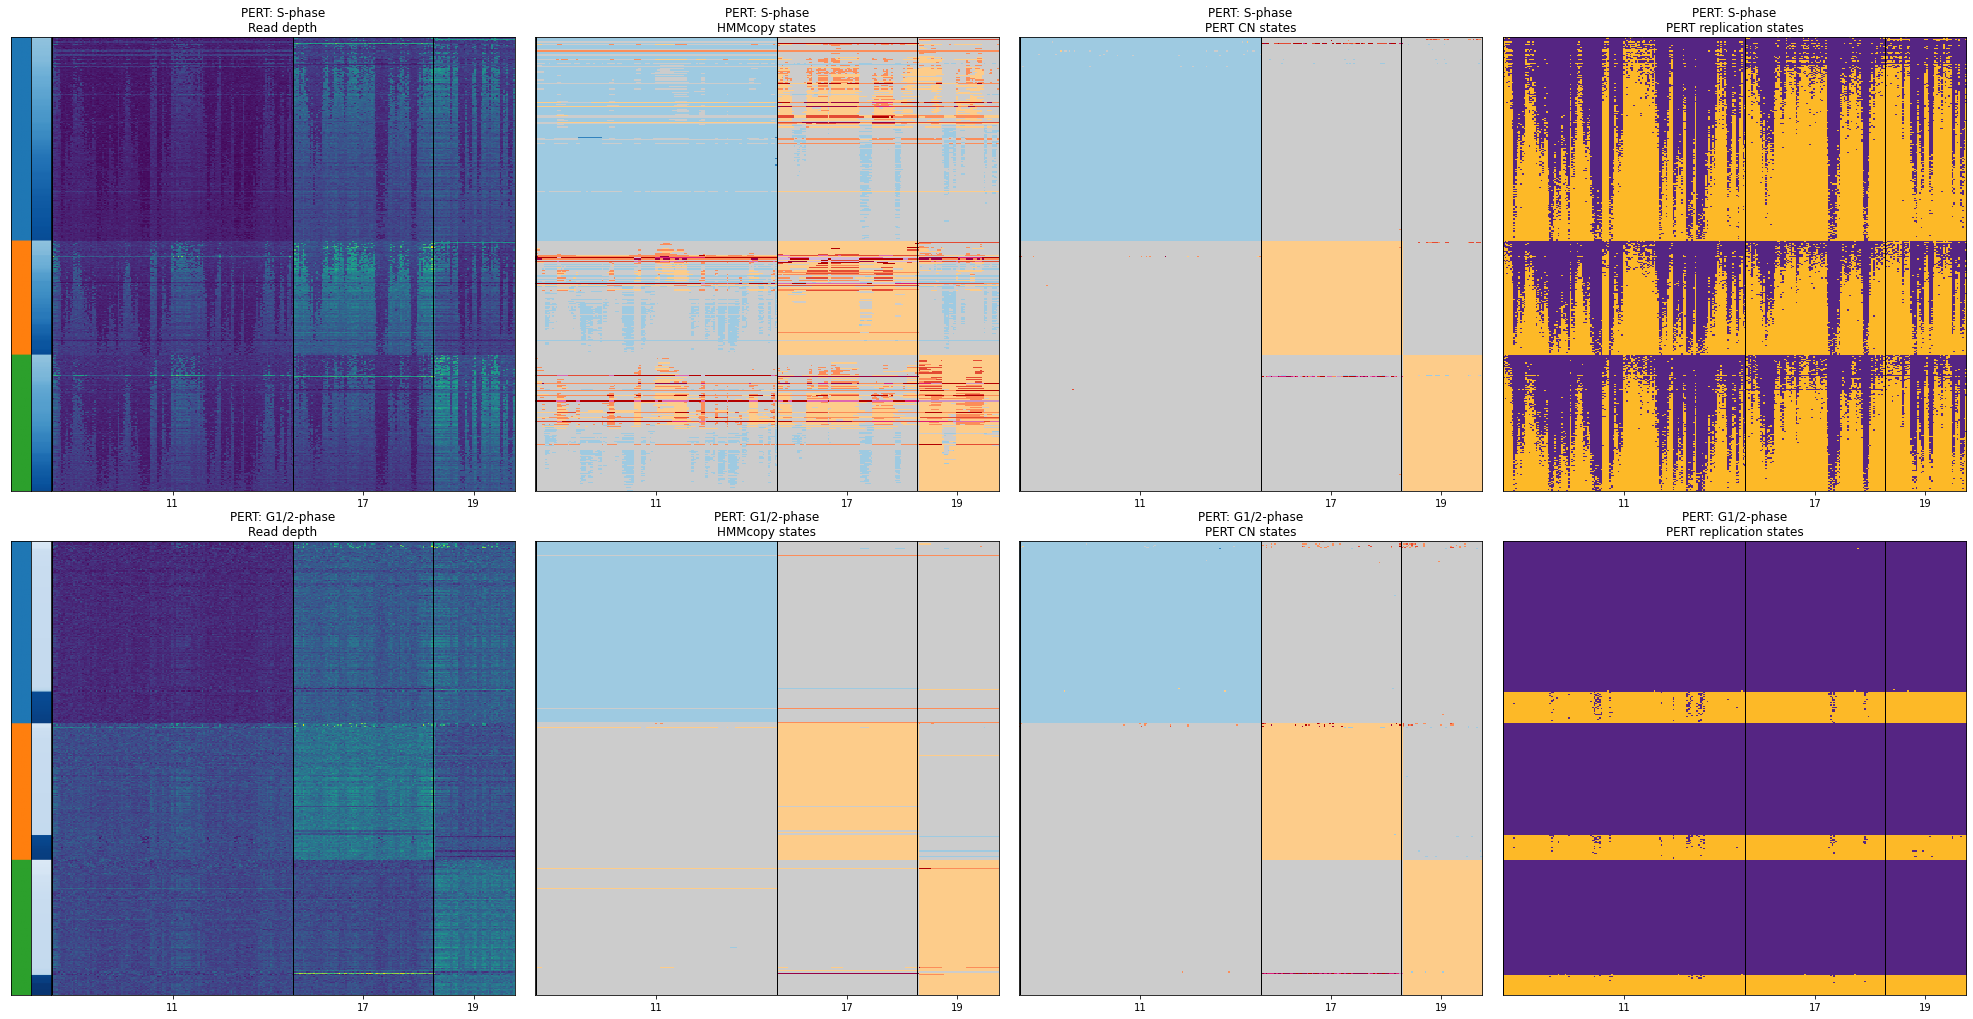

In [20]:
# plot the results of the inference, now sorted by the PERT predicted phase
plot_model_results(
    cn_s_out, cn_g_out, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states',
    top_title_prefix='PERT: S-phase', bottom_title_prefix='PERT: G1/2-phase'
)
plt.show()

Using the default threshold that S-phase cells have 5-95% of their loci replicated, PERT identifies 406 S-phase cells and 386 G1/2-phase cells which is very close to the true number of S-phase and G1/2-phase cells in the simulation. The phase errors arise from cells containing CNAs not seen in the high-confidence G1/2 input set and from very early and very late S-phase cells that have `<5%` and `>95%` replicated bins.

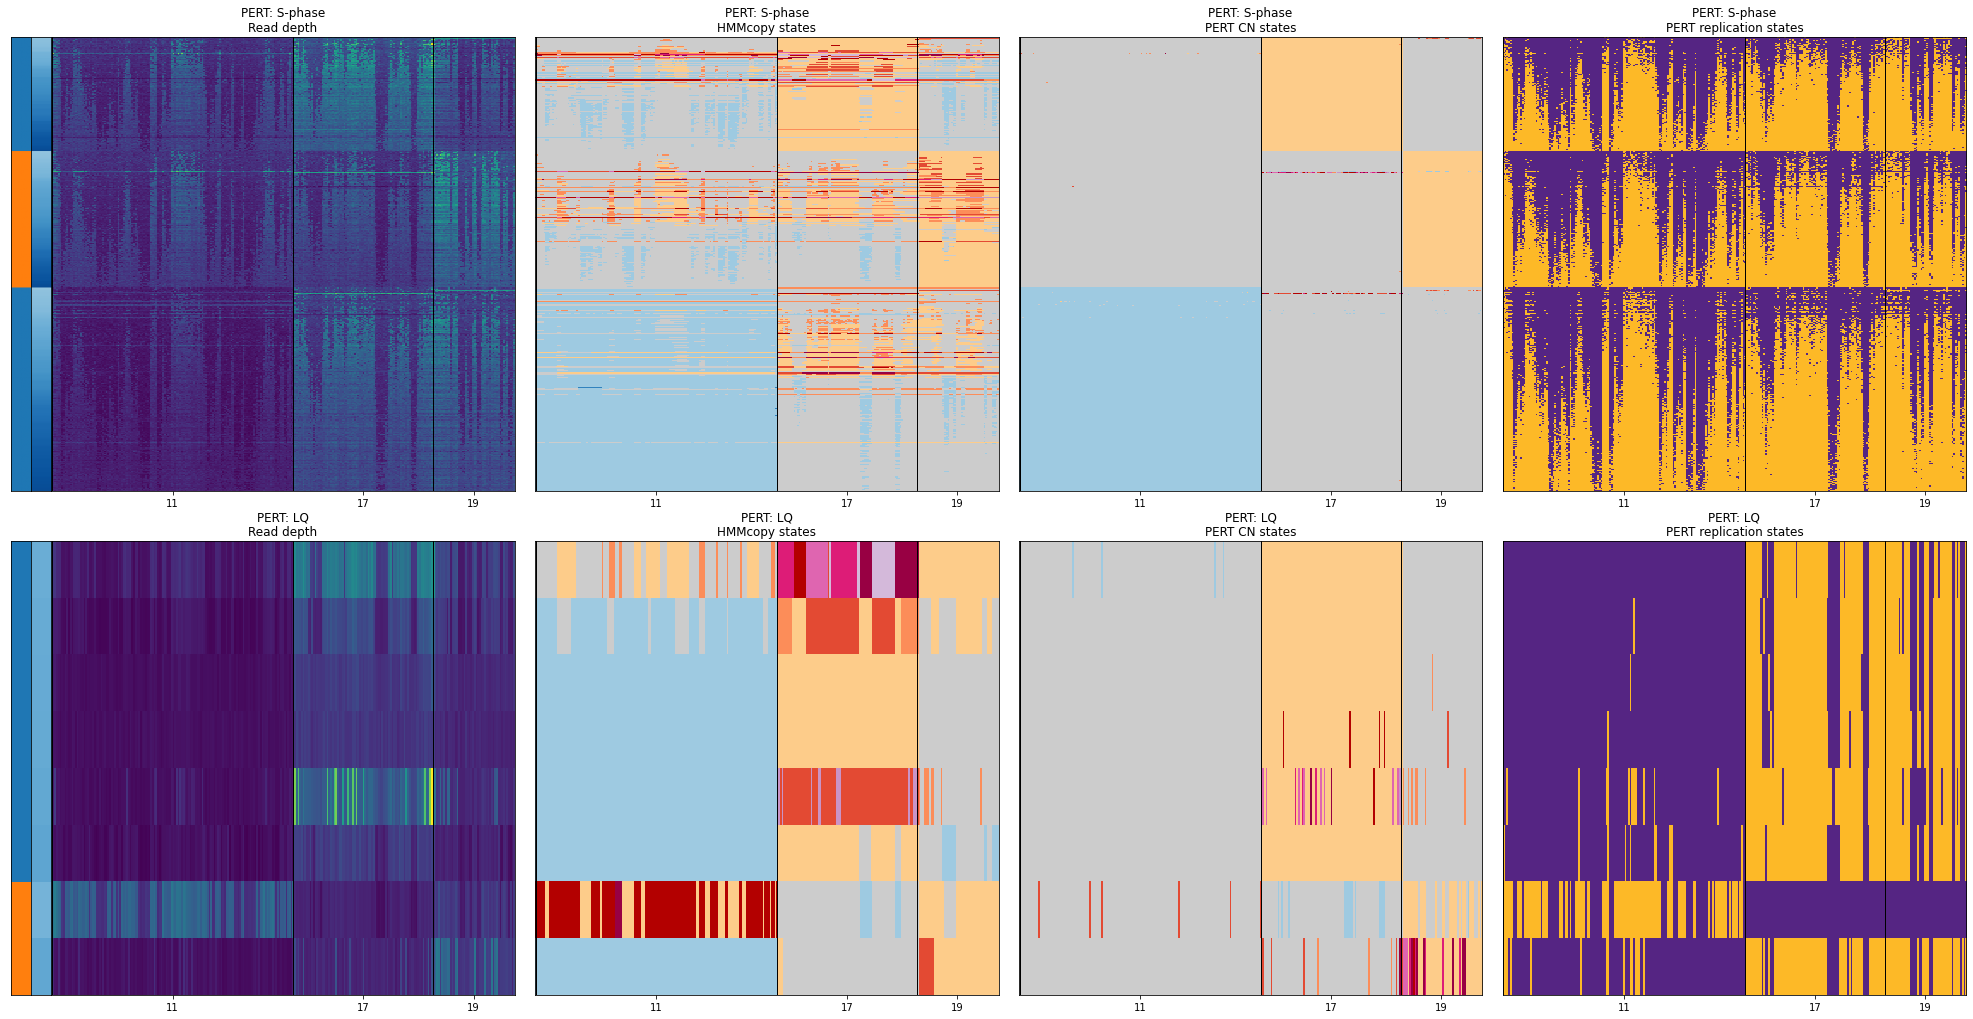

In [21]:
# show what the PERT predicted low-quality cells look like in contrast to the predicted S-phase cells
plot_model_results(
    cn_s_out, cn_lq_out, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states',
    top_title_prefix='PERT: S-phase', bottom_title_prefix='PERT: LQ'
)
plt.show()

In cases where cells are of true poor quality upon sequencing (i.e. not all chromosomes are sequenced due to lysis/tagmentation errors), PERT may use the latent replication state to explain this source of read depth variance. In contrast with DNA replication though, the effects of low quality are often on length scales larger than replication timing domains. Thus, these low quality cells will have high autocorrelation in their latent replication state and more PERT CN=0 bins than other true S-phase cells containing 5-95% replicated bins. In this setting of simulated data with no low quality cells, those falsely predicted as low quality are cells which explained CNAs as large replication events.

In [22]:
# merge the true time in S-phase with the PERT cell_frac_rep output for all cells
output_cell_times = pd.concat([
    cn_s_out[['cell_id', 'cell_frac_rep']].drop_duplicates(), 
    cn_g_out[['cell_id', 'cell_frac_rep']].drop_duplicates(), 
    cn_lq_out[['cell_id', 'cell_frac_rep']].drop_duplicates()
    ], ignore_index=True
)

true_cell_times = pd.concat([
    cn_s[['cell_id', 'true_t', 'true_phase']].drop_duplicates(), 
    cn_g1[['cell_id', 'true_t', 'true_phase']].drop_duplicates(), 
    ], ignore_index=True
)

cell_times = pd.merge(true_cell_times, output_cell_times, on='cell_id')

print(cell_times.shape)

cell_times.head()

(800, 4)


cell_id    true_t true_phase  cell_frac_rep
0    cell_S_0  0.526486          S       0.630996
1    cell_S_1  0.563934          S       0.634686
2   cell_S_10  0.845051          S       0.863469
3  cell_S_100  0.660656          S       0.671587
4  cell_S_101  0.658827          S       0.712177

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


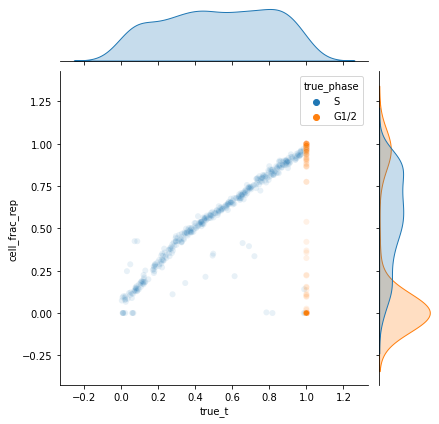

In [23]:
sns.jointplot(data=cell_times, x='true_t', y='cell_frac_rep', hue='true_phase', alpha=0.1)
plt.xlabel('True time in S-phase')
plt.ylabel('PERT predicted time in S-phase')
plt.show()

This plot gives a better perspective on how the discrepancies between true and predicted phases arise. Blue points along the diagonal are cells that were correctly predicted as S-phase. Orange points in the corners represent cells which are correctly predicted to as G1/2-phase. Orange points outside of the corners represent true G1/2-phase cells that PERT falsely predicts as S-phase. Blue points in the corners represent extremely early or late S-phase cells. Blue points along the middle-edges represent true S-phase cells that PERT falsely predicts as G1/2-phase. Blue points just off the diagonal represent correctly predicted S-phase cells that have disagreements between their per-bin replication states -- most of these cells are filtered out as being likely low quality.